In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로딩
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# TF-IDF 벡터화, X & y 값 지정
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000) # 불용어 (stopwords) 제거, 모두 소문자 처리, 가장 많이 나온 단어 100000개
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score

# Naive Bayes 모델
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

# SGDClassifier (Linear SVM) 모델
sgd_model = SGDClassifier(loss='hinge') # hinge loss 설정을 사용해 틀린 예측과 틀린 값에 가까운 예측을 penalize함
sgd_model.fit(X_train, y_train)
sgd_preds = sgd_model.predict(X_test)

# 평가 함수 - 각 모델의 평가 결과 레포트를 작성하는 함수
def evaluate_model(name, preds):
    print(f"\n📊 {name} 결과")
    print("Accuracy:", accuracy_score(y_test, preds)) #정확성, accuracy
    print("F1 Macro:", f1_score(y_test, preds, average='macro')) #f1 score, macro
    print(classification_report(y_test, preds)) 

evaluate_model("Naive Bayes", nb_preds)
evaluate_model("SGDClassifier", sgd_preds)


📊 Naive Bayes 결과
Accuracy: 0.6747211895910781
F1 Macro: 0.6461515436222018
              precision    recall  f1-score   support

           0       0.61      0.26      0.37       319
           1       0.61      0.68      0.65       389
           2       0.64      0.61      0.63       394
           3       0.60      0.69      0.64       392
           4       0.74      0.65      0.70       385
           5       0.79      0.76      0.78       395
           6       0.76      0.79      0.77       390
           7       0.75      0.70      0.73       396
           8       0.79      0.74      0.77       398
           9       0.88      0.79      0.84       397
          10       0.56      0.92      0.70       399
          11       0.74      0.75      0.74       396
          12       0.67      0.50      0.57       393
          13       0.83      0.75      0.79       396
          14       0.76      0.73      0.75       394
          15       0.42      0.90      0.58       398
     

In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer
import numpy as np

# Dataset 구성 - 데이터의 값, 즉 텍스트를 text로 지정, 텍스트의 카테고리를 label로 지정 후 딕셔너리로 변환
train_dataset = Dataset.from_dict({'text': newsgroups_train.data, 'label': newsgroups_train.target})
test_dataset = Dataset.from_dict({'text': newsgroups_test.data, 'label': newsgroups_test.target})

# Tokenizer 및 토큰화
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased") #미리 학습된 tokenizer 로딩

# 각 텍스트를 BERT모델이 이해 할 수 있는 토큰 ID로 변환하는 함수
def tokenize(example): 
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=512) # 512보다 길면 자르기, 길지 않으면 패딩하기
train_tokenized = train_dataset.map(tokenize, batched=True) # 함수 적용, 한 번에 한 줄이 아닌 한 번에 한 배치에 적용
test_tokenized = test_dataset.map(tokenize, batched=True)

# Hugging face dataset 형식으로 pytorch 형식으로 변환
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# 모델 로드
bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20)

# 평가 지표 함수 - 예측 이후 평가 지표를 계산 함: 정확성과 f1 score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1) # 가장 높은 예측 확률을 가진 카테고리를 설정
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

# Trainer 구성
training_args = TrainingArguments(
    output_dir="./results", # 예측과 체크포인트들이 저장되는 장소 지정
    per_device_train_batch_size=8, # 모델 트레이닝 시 한 배치에 8개의 샘플 지정  
    per_device_eval_batch_size=8,
    num_train_epochs=2, # 트레이닝 데이터셋을 2번 교육시킴 
    logging_dir="./logs" # 트레이닝 로그 저장 장소
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics
)

trainer.train() # 트레이닝 시작
bert_results = trainer.evaluate() # 트레이닝 결과 평가 및 반환
print("\n📊 BERT 결과")
print(bert_results)

Map:   0%|          | 0/11314 [00:00<?, ? examples/s]

Map:   0%|          | 0/7532 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.591900
1000,1.050600
1500,0.914800
2000,0.642300
2500,0.615000



📊 BERT 결과
{'eval_loss': 1.0366833209991455, 'eval_accuracy': 0.70817843866171, 'eval_f1_macro': 0.6940520854837733, 'eval_runtime': 1516.047, 'eval_samples_per_second': 4.968, 'eval_steps_per_second': 0.621, 'epoch': 2.0}


In [ ]:
# BERT_results 딕셔너리의 내부 값 확인인
for a in bert_results:
    print(a, bert_results[a])

eval_loss 1.0366833209991455
eval_accuracy 0.70817843866171
eval_f1_macro 0.6940520854837733
eval_runtime 1516.047
eval_samples_per_second 4.968
eval_steps_per_second 0.621
epoch 2.0


In [ ]:
# 혼돈 행렬을 시각화 하는 함수
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

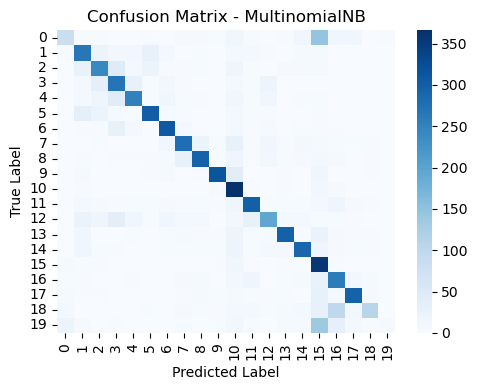

In [22]:
nb_preds = nb_model.predict(X_test)
plot_conf_matrix(y_test, nb_preds, "Confusion Matrix - MultinomialNB", "MultinomialNB_CM")

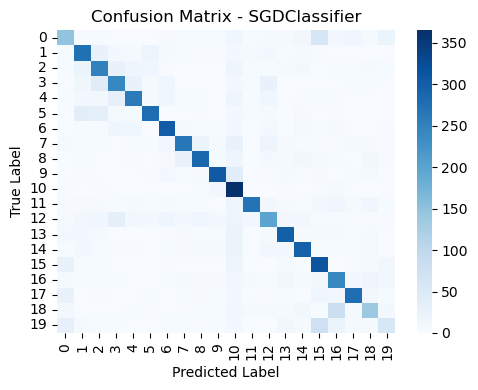

In [23]:
sgd_preds = sgd_model.predict(X_test)
plot_conf_matrix(y_test, sgd_preds, "Confusion Matrix - SGDClassifier", "SGDClassifier_CM")

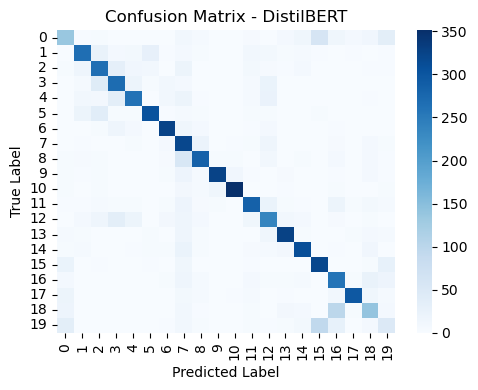

In [ ]:
import numpy as np

bert_preds_output = trainer.predict(test_tokenized) # 테스트 셋에 모델 예측
bert_preds = np.argmax(bert_preds_output.predictions, axis=1) # 각 샘플에 대해 가장 높은 확률을 가진 카테고리 인덱스 선택

# 예측 값인 bert_preds과 비교하기 위한 실제 답 추출출
y_test_bert = test_tokenized["label"]
plot_conf_matrix(y_test_bert, bert_preds, "Confusion Matrix - DistilBERT", "DistilBERT_CM")

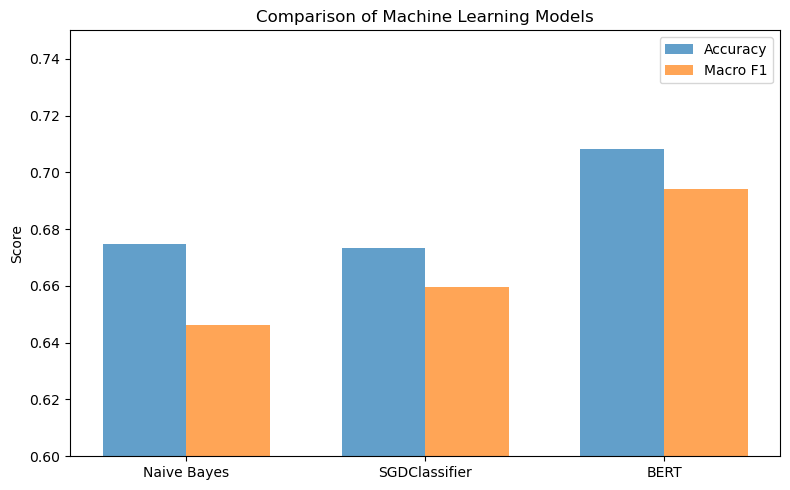

In [ ]:
import matplotlib.pyplot as plt

# 각 모델의 정확성과 f1 macro를 차트로 시각화
models = ['Naive Bayes', 'SGDClassifier', 'BERT']
accuracy = [accuracy_score(y_test, nb_preds), accuracy_score(y_test, sgd_preds), bert_results['eval_accuracy']]
f1_macro = [f1_score(y_test, nb_preds, average='macro'), f1_score(y_test, sgd_preds, average='macro'), bert_results['eval_f1_macro']]

plt.figure(figsize=(8, 5))
bar_width = 0.35
x = range(len(models))

plt.bar(x, accuracy, width=bar_width, label='Accuracy', alpha=0.7)
plt.bar([i + bar_width for i in x], f1_macro, width=bar_width, label='Macro F1', alpha=0.7)

plt.xticks([i + bar_width / 2 for i in x], models)
plt.ylim(0.6, 0.75)
plt.title('Comparison of Machine Learning Models')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()